Walkthrough:
1. Generate data (event sequence), get trajectories with different number of frames / observation lagtimes
2. readdy_learn: Least-squares fit of the small lagtime data, one basis function
3. Naive fit of large lagtime data -> works good, no surprise
4. readdy_learn: Least-squares fit of the large lagtime data -> does not work good
5. Explain differences of objective functions
6. readdy_learn: Least-squares with 4 basis functions -> worse than before
7. Introduce L1 penalty -> hopefully gets better (more basis functions also create more ambiguity)

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# abbreviation for plotting functions in certain range
def plot(f, xRange, *args, **kw):
    yRange = np.fromiter(map(f,xRange), float)
    plt.plot(xRange,yRange, *args, **kw)

## Generate data - bimolecular reaction
System is $A+B\rightarrow C$ with CME rate $\kappa$. 
Defining a volume $V$, the corresponding LMA rate is $\xi = V\kappa$.
The analytic solution to this is 

$$a(t) = \frac{a(0)}{1 + a(0)\, \kappa\, t}$$

In [12]:
def analytic_model_a(t, rate):
    return 50. / (1. + (50. * rate * t))

In [13]:
import pynumtools.kmc as kmc

n_species = 3
n_boxes = 1
rate = 2.
diffusivity_a = np.array([[0.]])
diffusivity_b = np.array([[0.]])
diffusivity_c = np.array([[0.]])
diffusivity = np.array([diffusivity_a, diffusivity_b, diffusivity_c])
init_state = np.array([[50, 50, 0]])
species_names = ["A", "B", "C"]
system = kmc.ReactionDiffusionSystem(diffusivity, 3, 1, init_state, species_names=species_names)
system.add_fusion("A", "B", "C", np.array([rate]))
system.simulate(1000)

[KMC] [2024-10-22 16:50:27] [INFO] Simulate for 1000 steps
[KMC] [2024-10-22 16:50:27] [INFO] No events possible / system is frustrated, at step 50


In [14]:
def get_counts_config(n_frames):
    counts, times = system.convert_events_to_time_series(n_frames=n_frames)
    # flatten out spatial dimension and convert to float
    counts = np.sum(counts, axis=1, dtype=float)
    config = system.get_trajectory_config()
    return counts, times, config

cnts_30, times_30, cfg_30 = get_counts_config(30)
cnts_50, times_50, cfg_50 = get_counts_config(50)
cnts_100, times_100, cfg_100 = get_counts_config(100)
cnts_500, times_500, cfg_500 = get_counts_config(500)
cnts_5000, times_5000, cfg_5000 = get_counts_config(5000)

[KMC] [2024-10-22 16:50:27] [INFO] got time step 0.013232494200744519 and n_frames 30
[KMC] [2024-10-22 16:50:27] [INFO] got time step 0.00793949652044671 and n_frames 50
[KMC] [2024-10-22 16:50:27] [INFO] got time step 0.003969748260223355 and n_frames 100
[KMC] [2024-10-22 16:50:27] [INFO] got time step 0.0007939496520446711 and n_frames 500
[KMC] [2024-10-22 16:50:27] [INFO] got time step 7.939496520446711e-05 and n_frames 5000


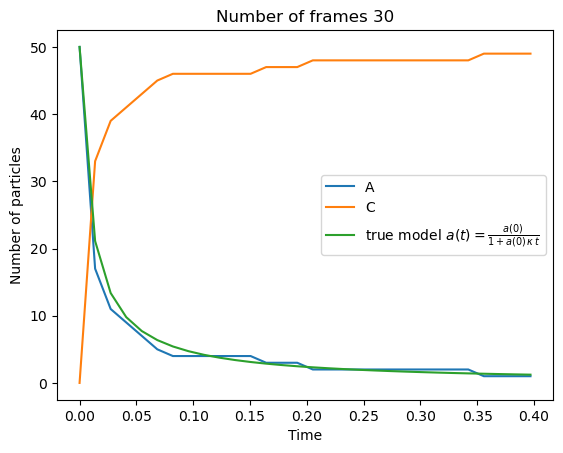

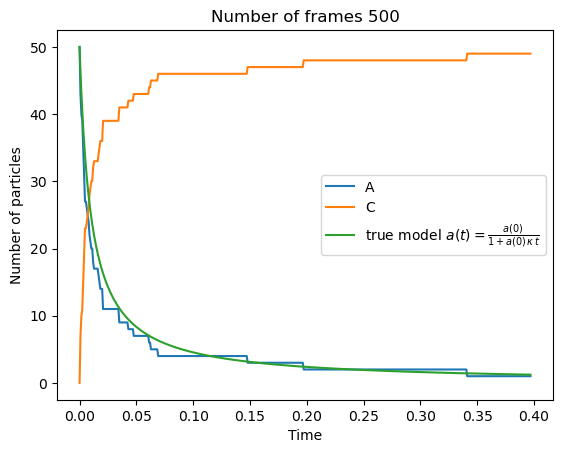

In [15]:
def plot_counts(counts, times, config):
    plt.plot(times, counts[:, config.types["A"]], label="A")
    #plt.plot(times, counts[:, config.types["B"]], label="B")
    plt.plot(times, counts[:, config.types["C"]], label="C")
    plot(lambda x: analytic_model_a(x, 2.), 
         times, label=r"true model $a(t) = \frac{a(0)}{1 + a(0)\, \kappa\, t}$")
    plt.legend(loc="best")
    plt.xlabel("Time")
    plt.ylabel("Number of particles")
    plt.title("Number of frames " + str(len(counts)))

plot_counts(cnts_30, times_30, cfg_30); plt.show();
#plot_counts(cnts_50, times_50, cfg_50); plt.show();
#plot_counts(cnts_100, times_100, cfg_100); plt.show();
plot_counts(cnts_500, times_500, cfg_500); plt.show();

## Naive fit of the analytic model
$$
\mathrm{min}_{\kappa} \left(
  \sum_t \left\lVert y_t - f_\kappa(t)\right\rVert^2 
\right)
$$

Fitted reaction rate:  2.427659608172089


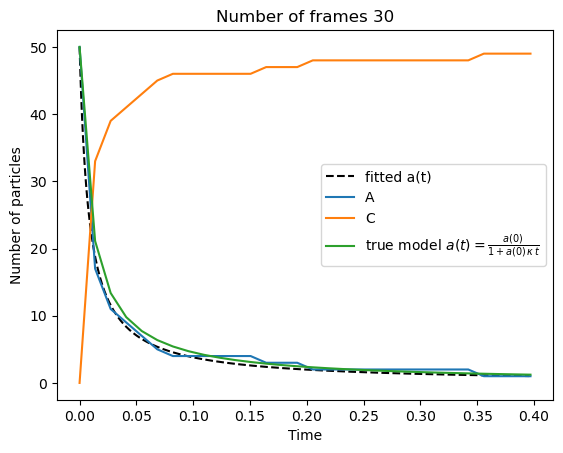

In [16]:
import scipy.optimize as so

cnts_naive = cnts_30
cfg_naive = cfg_30
times_naive = times_30

popt, pcov = so.curve_fit(analytic_model_a, times_naive, cnts_naive[:,0])
print("Fitted reaction rate: ", popt[0])
fitted_model = lambda x: analytic_model_a(x, popt[0])
plot(fitted_model, np.arange(0.,times_naive[-1], 0.001), "k--", label="fitted a(t)")
plot_counts(cnts_naive, times_naive, cfg_naive)

## readdy_learn
$$
\mathrm{min}_{\Xi} \left(
  \frac{1}{2T}
  \left\lVert \mathbf{\dot{X}} - \Theta(\mathbf{X})\Xi \right\rVert^2_F 
  + \alpha\lambda\lVert\Xi\rVert_1 + \alpha(1-\lambda)\lVert\Xi\rVert_2
\right)
$$

In [17]:
counts = cnts_500
times = times_500
config = cfg_500

### Load data into Trajectory object

In [19]:
import readdy_learn.tools as pat

traj = pat.Trajectory.from_counts(config, counts, times[1]-times[0])
traj.update()

ModuleNotFoundError: No module named 'readdy_learn.tools'

### Define ansatz reactions via the BasisFunctionConfiguration object

In [30]:
from py_analyze_tools.sklearn import BasisFunctionConfiguration

bfc = BasisFunctionConfiguration(n_species=traj.n_species)
bfc.add_fusion(0, 1, 2) # A + B -> C
#bfc.add_fission(2, 0, 1) # C -> A + B
#bfc.add_conversion(0, 2) # A -> C
#bfc.add_conversion(2, 0) # C -> A
right_rates = np.array([rate, 0., 0., 0.])

### Estimate model parameters using least-squares

In [43]:
from py_analyze_tools.sklearn import ReaDDyElasticNetEstimator

est = ReaDDyElasticNetEstimator(traj, bfc, 1., 
                                alpha=0., l1_ratio=1., method=None,
                                verbose=True, approx_jac=False, options={'ftol': 1e-12})
est.fit(None)
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)
print("right rates =%s" % right_rates)

optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
22 / 15000 iterations
coefficients=[ 1.45533867  0.          3.54306802  0.20693452]
right rates =[ 2.  0.  0.  0.]


### Results

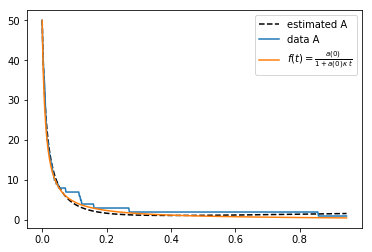

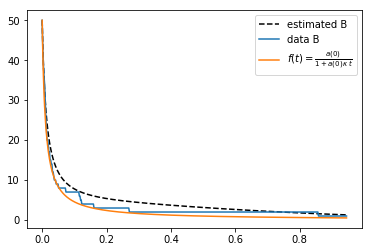

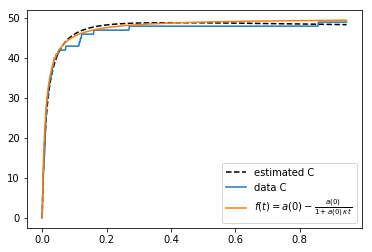

In [45]:
from scipy.integrate import odeint

def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(coefficients, theta)

estimated_realisation = odeint(fun, traj.counts[0], np.arange(0., traj.n_time_steps*traj.time_step, traj.time_step))
for t in ["A", "B", "C"]:
    type_id = config.types[t]
    plt.plot(times, estimated_realisation[:, type_id], "k--", label="estimated "+t)
    plt.plot(times, traj.counts[:, type_id], label="data "+t)
    if t=="A" or t=="B":
        plot(lambda x: analytic_model_a(x, 2.), times, label=r"$f(t) = \frac{a(0)}{1 + a(0)\, \kappa\, t}$")
    else:
        plot(lambda x: 50. - analytic_model_a(x, 2.),
             times, label=r"$f(t) =a(0) - \frac{a(0)}{1 + a(0)\, \kappa\, t}$")
    plt.legend(loc="best")
    plt.show()

### Summary:
- Our workflow is (obviously) different from fitting a time-dependent function to the data
- Our objective function has no explicit time-dependence, time-ordering is arbitrary, only the current state and a one-step delta contribute
- Our approach works good if the derivative, which has delta peaks or is zero, is resolved well
- Penalty terms prevent overfitting and thus finding the _essence_ of the system